<a href="https://colab.research.google.com/github/EduMoura321/Non-linear-systems/blob/main/reborn_classical_mechanics_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sympy as sp
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Usar "pretty printing" para saídas simbólicas
sp.init_printing(use_unicode=True)

In [2]:
### Defining Symbols
# t: time, g: gravity, M: Cart mass, m: Pendulum mass, l: Length
# k, k2: spring constants
# c_X, c_th1, c_th2: Damping coefficients
# F0, w: Amplitude and frequency of external force
t, g, M, m, l, k, k2 = sp.symbols('t g M m l k k2')
c_X, c_th1, c_th2 = sp.symbols('c_X c_theta1 c_theta2')
F0, w = sp.symbols('F0 omega')

# --- Generalized Coordinates (q) ---
X, th1, th2 = sp.symbols('X theta1 theta2')

# --- Generalized Velocities (dq/dt) ---
dX, dth1, dth2 = sp.symbols('dX dtheta1 dtheta2')

# Create lists for easier processing
q = [X, th1, th2]
dq = [dX, dth1, dth2]

print("Symbols defined.")

Symbols defined.


In [3]:
### Deriving the Lagrangian

# --- A. Positions of the masses ---
# (Using the "hanging" pendulum convention relative to the cart)
P1x = - X - l * sp.sin(th1)
P1y = l * sp.cos(th1)
P2x = P1x - l * sp.sin(th2)
P2y = P1y + l * sp.cos(th2)

# --- B. Velocities of the masses ---
v1x = P1x.diff(X) * dX + P1x.diff(th1)* dth1
v1y = P1y.diff(th1)* dth1
v2x = P2x.diff(X) * dX + P2x.diff(th1)* dth1 + P2x.diff(th2)* dth2
v2y = P2y.diff(th1)* dth1  + P2y.diff(th2)* dth2

# --- C. Kinetic Energy (T) ---
T_cart = sp.Rational(1, 2) * M * dX**2
T1 = sp.Rational(1, 2) * m * (v1x**2 + v1y**2)
T2 = sp.Rational(1, 2) * m * (v2x**2 + v2y**2)
T = T_cart + T1 + T2

# --- D. Potential Energy (V) ---
# Hanging pendulum + Nonlinear spring (Duffing potential) on cart
V = - m * g * P1y - m * g * P2y + sp.Rational(1,2)*(k * X**2) + sp.Rational(1,4)*(k2* X**4)

# --- E. Lagrangian (L) ---
L = (T - V)
print("Lagrangian L = T - V derived.")

Lagrangian L = T - V derived.


In [4]:
### Deriving the Hamiltonian

# --- A. Find Generalized Momenta (p_i) ---
pX = L.diff(dX)
pth1 = L.diff(dth1)
pth2 = L.diff(dth2)

# Symbols for the momenta themselves
pX_s, pth1_s, pth2_s = sp.symbols('p_X p_theta1 p_theta2')
p_syms = [pX_s, pth1_s, pth2_s]
q_syms = [X, th1, th2]

# --- B. Solve for Velocities (in terms of momenta) ---
print("Solving for velocities in terms of momenta...")
eq_pX = pX - pX_s
eq_pth1 = pth1 - pth1_s
eq_pth2 = pth2 - pth2_s
vel_sols = sp.solve([eq_pX, eq_pth1, eq_pth2], [dX, dth1, dth2])
print("Velocities solved.")

# --- C. Define the Hamiltonian (H) ---
H = pX_s * dX + pth1_s * dth1 + pth2_s * dth2 - L
H = H.subs(vel_sols)
H = sp.simplify(H)
print("Hamiltonian H(q, p) derived.")

Solving for velocities in terms of momenta...
Velocities solved.
Hamiltonian H(q, p) derived.


In [5]:
### Obtaining the 6 ODEs (Hamilton + Non-Conservative Forces)

# --- Find d(q)/dt = ∂H/∂p ---
dq_dt = [sp.simplify(H.diff(p)) for p in p_syms]

# --- Find the CONSERVATIVE part of d(p)/dt = -∂H/∂q ---
dp_dt_conservative = [sp.simplify(-H.diff(q)) for q in q_syms]

# --- Define Non-Conservative Forces (Damping & External) ---

# 1. Damping forces (Q_damp = -c*dq)
Q_damp_X = -c_X * dX
Q_damp_th1 = -c_th1 * dth1
Q_damp_th2 = -c_th2 * dth2
Q_damp_list = [Q_damp_X, Q_damp_th1, Q_damp_th2]

# 2. External forces (F(t) on cart)
Q_ext_X = F0 * sp.cos(w * t)
Q_ext_th1 = 0
Q_ext_th2 = 0
Q_ext_list = [Q_ext_X, Q_ext_th1, Q_ext_th2]

# --- Substitute velocities (dq) with momenta (p) in damping forces ---
# The forces must be expressed in terms of p and q, not dq
Q_damp_list_p = [force.subs(vel_sols) for force in Q_damp_list]

# --- Combine all forces to get the final d(p)/dt ---
dp_dt_final = []
for i in range(3):
    # dp/dt = -dH/dq + Q_external + Q_damping
    eq = dp_dt_conservative[i] + Q_ext_list[i] + Q_damp_list_p[i]
    dp_dt_final.append(sp.simplify(eq))

# This is our final system of 6 first-order ODEs
dZ_dt_sym = dq_dt + dp_dt_final # [dX, dth1, dth2, dpX, dpth1, dpth2]
print("Derived 6 symbolic ODEs including damping and external forces.")

Derived 6 symbolic ODEs including damping and external forces.


In [19]:
### Numerical Function (Lambdify)

# --- A. Create the Numerical Function ---
state_syms = q_syms + p_syms # [X, th1, th2, p_X, p_th1, p_th2]
param_syms = [M, m, l, g, k, k2, c_X, c_th1, c_th2, F0, w]

# Add 't' as argument for the time-dependent force
dZ_dt_num = sp.lambdify([t] + state_syms + param_syms, dZ_dt_sym, 'numpy')

# --- B. Define the ODE Function for SciPy ---
def odefunc(t, Z, M_val, m_val, l_val, g_val, k_val, k2_val, c_X_val, c_th1_val, c_th2_val, F0_val, w_val):
    # Z is a single vector: [X, th1, th2, p_X, p_th1, p_th2]
    # *Z "unpacks" this vector to match the arguments of dZ_dt_num
    return dZ_dt_num(t, *Z, M_val, m_val, l_val, g_val, k_val, k2_val, c_X_val, c_th1_val, c_th2_val, F0_val, w_val)

print("Numerical function 'odefunc' created.")


SyntaxError: invalid syntax (<lambdifygenerated-3>, line 1)

In [ ]:
### Simulation WITH Events (Continuous + Escape Safety)

# --- A. Define Parameters ---
params = {
    'M': 10,      # kg (cart mass)
    'm': 0.2,                    # kg (pendulum mass)
    'l': 0.5,                    # m (pendulum length)
    'g': 9.81,                   # m/s^2
    'k': -10.0,              # Linear spring
    'k2': 10.0,            # Non-linear spring (Softening)
    'c_X': 0.05,                  # Damping on cart
    'c_th1': 0.01,               # Damping on pendulum 1
    'c_th2': 0.01,               # Damping on pendulum 2
    'F0': 2.6,            # External Force Amplitude
    'w': 1.3                     # External Force Frequency (rad/s)
}

# Ensure the order matches param_syms in Cell 5
param_tuple = (
    params['M'], params['m'], params['l'], params['g'],
    params['k'], params['k2'],
    params['c_X'], params['c_th1'], params['c_th2'],
    params['F0'], params['w']
)

# --- B. Define Initial Conditions and Time ---
Z0 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
tf = 500  # Tempo final da simulação
t_span = [0, tf]
t_eval = np.arange(0, tf, 0.01) # High resolution

# --- NEW: Define the Escape Event ---
def escape_event(t, Z, *args):
    # Z[0] is the position X.
    # The critical "cliff" is around 0.69m. We stop if it passes 2.0m.
    return 2.0 - abs(Z[0])

escape_event.terminal = True  # Stop the simulation if this returns 0
escape_event.direction = -1   # Trigger only when crossing from positive to negative (distance decreases)

print(f"Starting simulation with escape detection from t={t_span[0]} to t={t_span[1]}...")

# --- C. Run Simulation ---
sol = solve_ivp(
    odefunc,
    t_span,
    Z0,
    t_eval=t_eval,
    method='LSODA',
    args=param_tuple,
    events=escape_event,   # <--- Added Safety Brake
    rtol=1e-8,
    atol=1e-10
)

# --- D. Check Status ---
if sol.status == 1:
    print(f"⚠️ Simulation stopped early! The cart escaped at t={sol.t[-1]:.3f}s (X = {sol.y[0][-1]:.3f}m)")
elif sol.status == 0:
    print("Simulation finished successfully (Cart stayed bounded).")

# --- E. Prepare variables for plotting ---
t_sol_boundary = sol.t
X_b, th1_b, th2_b, pX_b, pth1_b, pth2_b = sol.y

print("Results processed and ready to plot.")

Starting simulation with escape detection from t=0 to t=500...
Simulation finished successfully (Cart stayed bounded).
Results processed and ready to plot.


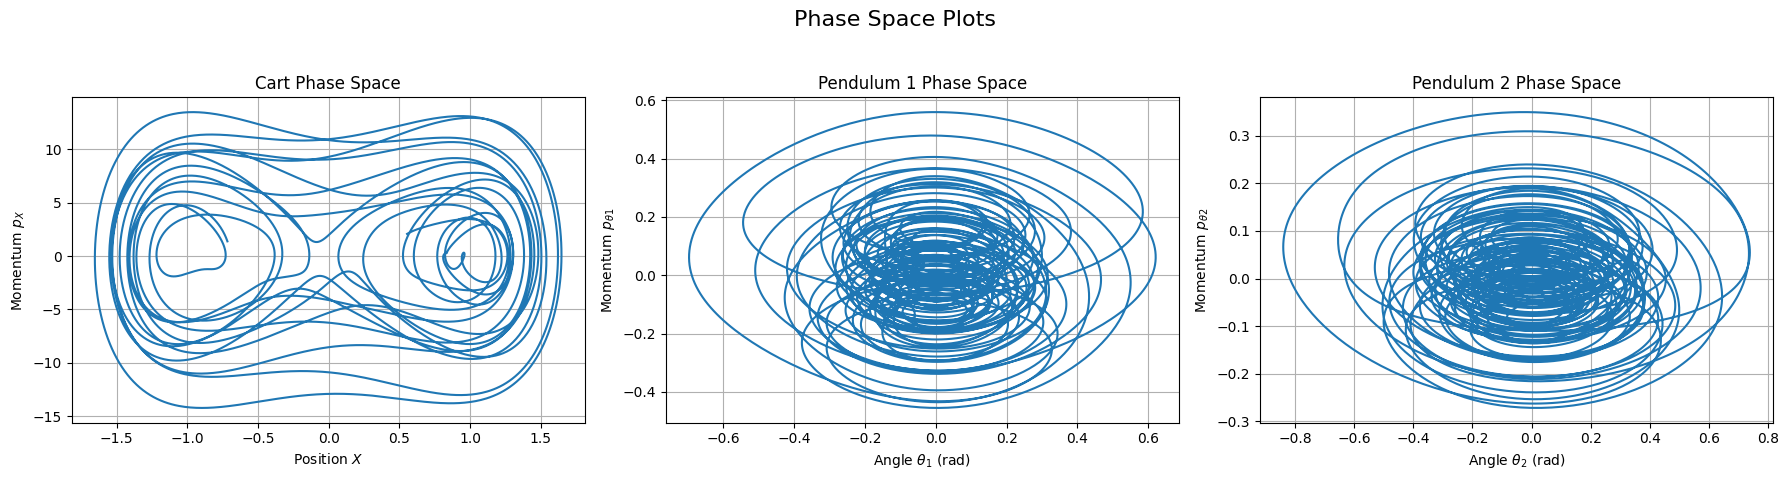

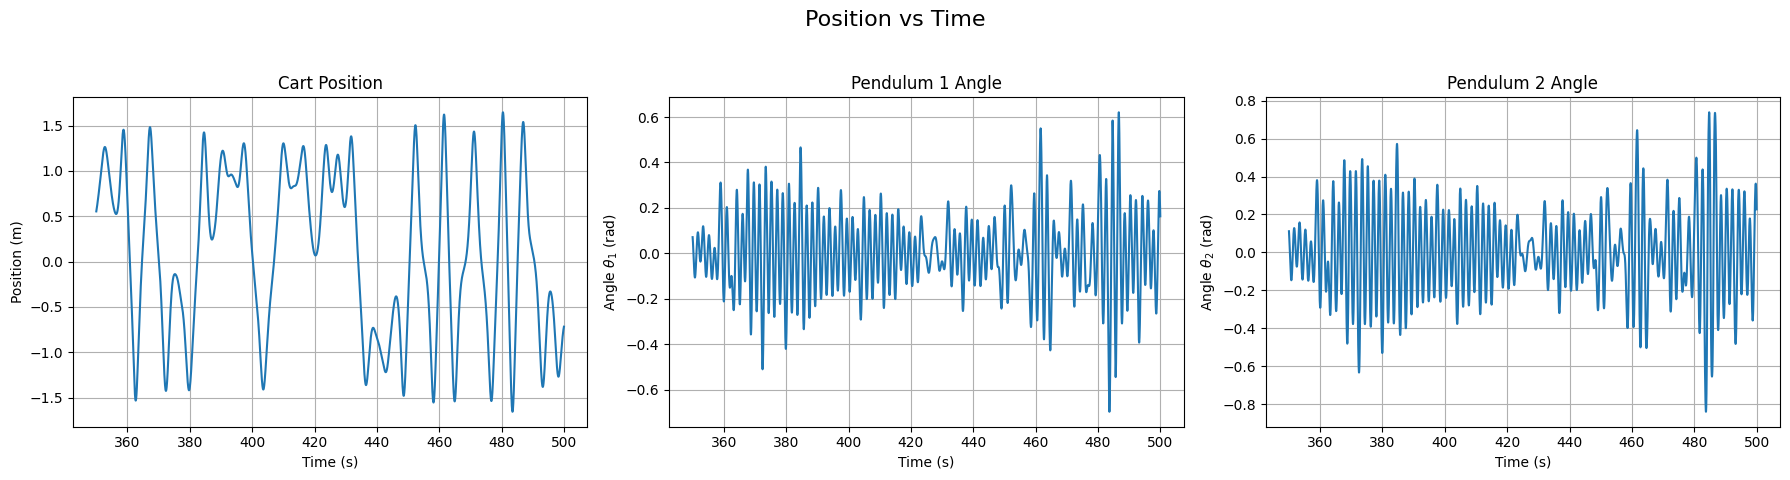

In [8]:
### Plots (Using the continuous results)
#aplicar transiente
t_trs = 0.7*tf # Plota só os últimos % da simulação


ind = np.where(t_sol_boundary >= t_trs)[0]
xt = X_b[ind]
th1t = th1_b[ind]
th2t = th2_b[ind]
pxt = pX_b[ind]
pth1t = pth1_b[ind]
pth2t = pth2_b[ind]
ttr = t_sol_boundary[ind]
#_-------------------------------------------------------
# --- A. Create Plots: Phase Space ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Phase Space Plots', fontsize=16)

# Plot 1: Cart Phase Space
axes[0].plot(xt, pxt)
axes[0].set_title('Cart Phase Space')
axes[0].set_ylabel('Momentum $p_X$')
axes[0].set_xlabel('Position $X$')
axes[0].grid(True)

# Plot 2: Pendulum 1 Phase Space
axes[1].plot(th1t, pth1t)
axes[1].set_title('Pendulum 1 Phase Space')
axes[1].set_ylabel('Momentum $p_{\\theta 1}$')
axes[1].set_xlabel('Angle $\\theta_1$ (rad)')
axes[1].grid(True)

# Plot 3: Pendulum 2 Phase Space
axes[2].plot(th2t, pth2t)
axes[2].set_title('Pendulum 2 Phase Space')
axes[2].set_ylabel('Momentum $p_{\\theta 2}$')
axes[2].set_xlabel('Angle $\\theta_2$ (rad)')
axes[2].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- B. Create Plots: Position vs. Time ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Position vs Time', fontsize=16)

# Plot 4: Cart Position
axes[0].plot(ttr, xt)
axes[0].set_title('Cart Position')
axes[0].set_ylabel('Position (m)')
axes[0].set_xlabel('Time (s)')
axes[0].grid(True)

# Plot 5: Pendulum 1 Position
axes[1].plot(ttr, th1t)
axes[1].set_title('Pendulum 1 Angle')
axes[1].set_ylabel('Angle $\\theta_1$ (rad)')
axes[1].set_xlabel('Time (s)')
axes[1].grid(True)

# Plot 6: Pendulum 2 Position
axes[2].plot(ttr, th2t)
axes[2].set_title('Pendulum 2 Angle')
axes[2].set_ylabel('Angle $\\theta_2$ (rad)')
axes[2].set_xlabel('Time (s)')
axes[2].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [17]:
#aplicar lyapunov classico sob para analise definitiva do caos
#Eduardo Moura

#definir matrizes e entradas

params = {
    'ndim': 6,
    'M': 10,      # kg (cart mass)
    'm': 0.2,                    # kg (pendulum mass)
    'l': 0.5,                    # m (pendulum length)
    'g': 9.81,                   # m/s^2
    'k': -10.0,              # Linear spring
    'k2': 10.0,            # Non-linear spring (Softening)
    'c_X': 0.05,                  # Damping on cart
    'c_th1': 0.01,               # Damping on pendulum 1
    'c_th2': 0.01,               # Damping on pendulum 2
    'F0': 2.6,            # External Force Amplitude
    'w': 1.3                     # External Force Frequency (rad/s)
}

# Ensure the order matches param_syms in Cell 5
params = ( params['ndim'],
    params['M'], params['m'], params['l'], params['g'],
    params['k'], params['k2'],
    params['c_X'], params['c_th1'], params['c_th2'],
    params['F0'], params['w']
)
#------------------------------------------------------------------
ndim = 6 #numero de dimensoes
t_total = 50 #seg (tempo de simulacao)
dt_renorm = 0.05 #seg(janela de tempo p renormalizacao do GSR)
step = int(t_total/dt_renorm)
x0 = np.array([0.1,0.1,0.1,0.1,0.0,0.0])
V0 = np.eye(ndim)
def f_func2(t, Z, parms):
  return f_func2(t,Z)
def jacobian(X, params):
  return JX
#=====================================================================
def sys_aum(t, Z, ndim, params):
  X = Z[:ndim]
  V = Z[ndim:].reshape((ndim,ndim))
  dxdt = f_func2(t, X, params)
  dydt = jacobian(X, params) @ V
  return np.concatenate([dxdt, dydt.flatten()])
Y = np.concatenate([x0, V0.flatten()])
S = np.zeros(ndim)
#--------------------------------------------------------------------
#loop de intg
t0 = 0.0
for i in range(step):
  sol_lp = solve_ivp(sys_aum,[t0, t0 + dt_renorm], Y, args=(params,), method='LSODA')
  Y = sol_lp.y[:, -1]
  X = Y[:ndim]
  V = Y[ndim:].reshape((ndim,ndim))

  #performa GSR
  Q, R = np.linalg.qr(V)

  S += np.log(np.abs(np.diag(R)))
  V = Q
  Y = np.concatenate([X, V.flatten()])
  t0 += dt_renorm
t_lap = 0.7*t_toal
lyap = S/t_lap
print('Lyapunov expoents', lyap)



TypeError: sys_aum() takes 4 positional arguments but 14 were given

In [9]:
# Basin of attraction - PRO CARRINHO, USANDO RK45, 40s de decisão, 50x50
# Luis Spengler

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from joblib import Parallel, delayed
import time

# --- 1. Configuration ---
resolution = 50        # Grid size (100x100 pixels). Increase to 200 or 300 for HD later.
tf_basin = 40           # Shorter time is enough to decide the "fate" of the cart
x_min, x_max = -2.0, 2.0
px_min, px_max = -8.0, 8.0

# Generate the grid
x_vals = np.linspace(x_min, x_max, resolution)
px_vals = np.linspace(px_min, px_max, resolution)

print(f"preparing to compute {resolution*resolution} trajectories...")

# --- 2. The 'Judge' Function (Runs one simulation) ---
def compute_basin_pixel(i, j, x0, px0):
    # Construct Initial State Z0
    # [X, th1, th2, pX, pth1, pth2]
    # We vary X and pX. We set pendulums to small non-zero values to allow coupling.
    Z_pixel = [x0, 0.05, 0.05, px0, 0.0, 0.0]

    # Run Simulation
    sol = solve_ivp(
        odefunc,
        [0, tf_basin],
        Z_pixel,
        args=param_tuple, # Uses the params defined in your previous cell
        method='RK45',    # RK45 is fine since we fixed the stiffness with M=10
        rtol=1e-5,        # Lower precision is okay for basins (we just need the sign)
        atol=1e-5
    )

    # The Verdict: Where did it end up?
    if sol.status == 0: # If simulation finished successfully
        x_final = sol.y[0][-1]
        if x_final > 0:
            return 1  # Right Basin (Yellow)
        else:
            return 0  # Left Basin (Blue/Purple)
    else:
        return -1 # Escaped/Error (Black)

# --- 3. Run Parallel Simulation ---
start_time = time.time()

# This loop uses all available CPU cores (-1)
results = Parallel(n_jobs=-1)(
    delayed(compute_basin_pixel)(i, j, x_vals[j], px_vals[i])
    for i in range(resolution)    # Rows (Momentum)
    for j in range(resolution)    # Cols (Position)
)

end_time = time.time()
print(f"Calculation complete in {end_time - start_time:.2f} seconds.")

# --- 4. Reconstruct and Plot the Image ---
# The results come back as a flat list, we need to reshape into a 2D grid
basin_grid = np.array(results).reshape(resolution, resolution)

plt.figure(figsize=(10, 8))
# Plot with 'origin=lower' so pX increases upwards
plt.imshow(basin_grid, extent=[x_min, x_max, px_min, px_max], origin='lower', cmap='viridis', aspect='auto')

plt.colorbar(label='Final Well (0=Left, 1=Right)')
plt.title(f'Basin of Attraction (Double-Well Chaos)\nResolution: {resolution}x{resolution}', fontsize=14)
plt.xlabel('Initial Position $X_0$ (m)', fontsize=12)
plt.ylabel('Initial Momentum $p_{X0}$', fontsize=12)

# Add overlay of the "Wall"
plt.axvline(0, color='white', linestyle='--', alpha=0.3, label='Central Barrier')
plt.legend()
plt.tight_layout()
plt.show()

preparing to compute 2500 trajectories...


KeyboardInterrupt: 

In [ ]:
### SIMPLES, SÓ PRA TESTAR
# Basin of attraction - PRO CARRINHO, USANDO LSODA, 40s de decisão, 50x50

import sympy as sp
import numpy as np
import math
from scipy.integrate import solve_ivp
from numba import njit
from joblib import Parallel, delayed
import time
from sympy.printing.pycode import pycode

# --- 1. Generate the Fast Code from SymPy ---
print("Compiling equations to Machine Code (Numba)...")

# Use the dZ_dt_sym you defined in the earlier symbolic cell
deriv_exprs = dZ_dt_sym

# Generate the lines of code for the derivatives
code_lines = []
for i, expr in enumerate(deriv_exprs):
    code_lines.append(f"    dZ_{i} = {pycode(expr)}")

func_body = "\n".join(code_lines)
return_statement = "    return np.array([" + ", ".join([f"dZ_{i}" for i in range(6)]) + "])"

# --- THE FIX: Align ALL variable names with SymPy's internal names ---
func_str = f"""
import math
import numpy as np

def fast_ode_func(t, Z, params):
    # 1. State Variables (Must match: X, theta1, theta2, p_X, p_theta1, p_theta2)
    X, theta1, theta2, p_X, p_theta1, p_theta2 = Z

    # 2. Parameters (Must match SymPy names: c_theta1, c_theta2, omega)
    # The ORDER comes from your param_tuple, but the NAMES must match SymPy
    M, m, l, g, k, k2, c_X, c_theta1, c_theta2, F0, omega = params

{func_body}
{return_statement}
"""

# Execute the string to create the function in Python
exec(func_str, globals())

# Compile it with Numba (Machine Code)
fast_ode_numba = njit(fast_ode_func)
print("Compiling complete. The physics engine is now C-speed.")

# --- 2. Define the Wrapper for Solve_IVP ---
@njit
def odefunc_numba(t, Z, args):
    return fast_ode_numba(t, Z, args)

# --- 3. Run the High-Res Basin Map ---
res_fast = 50       # res_fast x res_fast Grid
tf_fast = 40         # tf_fast seconds duration
param_arr = np.array(param_tuple)

print(f"Starting High-Res Simulation ({res_fast}x{res_fast})...")

def compute_pixel_fast(i, j, x0, px0):
    # Initial State: [X, theta1, theta2, pX, p_theta1, p_theta2]
    Z_pixel = np.array([x0, 0.05, 0.05, px0, 0.0, 0.0])

    # LSODA is excellent for stiff mechanical systems
    sol = solve_ivp(
        odefunc_numba,
        [0, tf_fast],
        Z_pixel,
        args=(param_arr,),
        method='LSODA',
        rtol=1e-3,        # Relaxed tolerance for speed
        atol=1e-3
    )

    if sol.status == 0:
        if sol.y[0][-1] > 0: return 1.0 # Right Basin
        else: return 0.0 # Left Basin
    return -1.0

# Define Grid
x_final = 2.5
px_final = 15
x_vals = np.linspace(-x_final, x_final, res_fast)
px_vals = np.linspace(-px_final, px_final, res_fast)

# Run Parallel Search
start = time.time()
results = Parallel(n_jobs=-1)(
    delayed(compute_pixel_fast)(i, j, x_vals[j], px_vals[i])
    for i in range(res_fast)
    for j in range(res_fast)
)
duration = time.time() - start

print(f"Finished {res_fast*res_fast} pixels in {duration:.2f} seconds!")

# --- 4. Plot ---
grid = np.array(results).reshape(res_fast, res_fast)

plt.figure(figsize=(12, 10))
plt.imshow(grid, extent=[-x_final, x_final, -px_final, px_final], origin='lower', cmap='viridis', aspect='auto') #plasma, inferno, blues , managua
plt.title(f'High-Res Basin of Attraction\nComputed in {duration:.1f}s | Method: LSODA + Numba', fontsize=14)
plt.xlabel('Initial Position $X_0$ (m)', fontsize=12)
plt.ylabel('Initial Momentum $p_{X0}$', fontsize=12)
plt.colorbar(label='Final Well (0=Left, 1=Right)')
plt.show()

In [ ]:
# Basin of attraction - PRO CARRINHO, USANDO LSODA, 40s de decisão, GRANDE RESOLUÇÃO

import sympy as sp
import numpy as np
import math
from scipy.integrate import solve_ivp
from numba import njit
from joblib import Parallel, delayed
import time
from sympy.printing.pycode import pycode

# --- 1. Generate the Fast Code from SymPy ---
print("Compiling equations to Machine Code (Numba)...")

# Use the dZ_dt_sym you defined in the earlier symbolic cell
deriv_exprs = dZ_dt_sym

# Generate the lines of code for the derivatives
code_lines = []
for i, expr in enumerate(deriv_exprs):
    code_lines.append(f"    dZ_{i} = {pycode(expr)}")

func_body = "\n".join(code_lines)
return_statement = "    return np.array([" + ", ".join([f"dZ_{i}" for i in range(6)]) + "])"

# --- THE FIX: Align ALL variable names with SymPy's internal names ---
func_str = f"""
import math
import numpy as np

def fast_ode_func(t, Z, params):
    # 1. State Variables (Must match: X, theta1, theta2, p_X, p_theta1, p_theta2)
    X, theta1, theta2, p_X, p_theta1, p_theta2 = Z

    # 2. Parameters (Must match SymPy names: c_theta1, c_theta2, omega)
    # The ORDER comes from your param_tuple, but the NAMES must match SymPy
    M, m, l, g, k, k2, c_X, c_theta1, c_theta2, F0, omega = params

{func_body}
{return_statement}
"""

# Execute the string to create the function in Python
exec(func_str, globals())

# Compile it with Numba (Machine Code)
fast_ode_numba = njit(fast_ode_func)
print("Compiling complete. The physics engine is now C-speed.")

# --- 2. Define the Wrapper for Solve_IVP ---
@njit
def odefunc_numba(t, Z, args):
    return fast_ode_numba(t, Z, args)

# --- 3. Run the High-Res Basin Map ---
res_fast = 1000       # 200x200 Grid
tf_fast = 40         # 20 seconds duration
param_arr = np.array(param_tuple)

print(f"Starting High-Res Simulation ({res_fast}x{res_fast})...")

def compute_pixel_fast(i, j, x0, px0):
    # Initial State: [X, theta1, theta2, pX, p_theta1, p_theta2]
    Z_pixel = np.array([x0, 0.05, 0.05, px0, 0.0, 0.0])

    # LSODA is excellent for stiff mechanical systems
    sol = solve_ivp(
        odefunc_numba,
        [0, tf_fast],
        Z_pixel,
        args=(param_arr,),
        method='LSODA',
        rtol=1e-3,        # Relaxed tolerance for speed
        atol=1e-3
    )

    if sol.status == 0:
        if sol.y[0][-1] > 0: return 1.0 # Right Basin
        else: return 0.0 # Left Basin
    return -1.0

# Define Grid
x_final = 2.5
px_final = 15
x_vals = np.linspace(-x_final, x_final, res_fast)
px_vals = np.linspace(-px_final, px_final, res_fast)

# Run Parallel Search
start = time.time()
results = Parallel(n_jobs=-1)(
    delayed(compute_pixel_fast)(i, j, x_vals[j], px_vals[i])
    for i in range(res_fast)
    for j in range(res_fast)
)
duration = time.time() - start

print(f"Finished {res_fast*res_fast} pixels in {duration:.2f} seconds!")

# --- 4. Plot ---
grid = np.array(results).reshape(res_fast, res_fast)

plt.figure(figsize=(12, 10))
plt.imshow(grid, extent=[-x_final, x_final, -px_final, px_final], origin='lower', cmap='viridis', aspect='auto') #plasma, inferno, blues , managua
plt.title(f'High-Res Basin of Attraction\nComputed in {duration:.1f}s | Method: LSODA + Numba', fontsize=14)
plt.xlabel('Initial Position $X_0$ (m)', fontsize=12)
plt.ylabel('Initial Momentum $p_{X0}$', fontsize=12)
plt.colorbar(label='Final Well (0=Left, 1=Right)')
plt.show()

In [ ]:

# --- Configuration ---
res_chaos = 1000          # Resolution (200x200 is great for this)
tf_chaos = 40            # Slightly longer time to let chaos accumulate
param_arr = np.array(param_tuple) # Ensure this is an array for Numba

print(f"Mapping Pendulum 2 Intensity ({res_chaos}x{res_chaos})...")

# --- The New 'Judge' Function ---
def compute_pendulum_intensity_fast(i, j, x0, px0):
    # Initial State: [X, theta1, theta2, pX, p_theta1, p_theta2]
    # We give the pendulums a tiny nudge (0.05) to wake them up
    Z_pixel = np.array([x0, 0.05, 0.05, px0, 0.0, 0.0])

    sol = solve_ivp(
        odefunc_numba,
        [0, tf_chaos],
        Z_pixel,
        args=(param_arr,),
        method='LSODA',
        rtol=1e-3,
        atol=1e-3
    )

    if sol.status == 0:
        # METRIC: Total Angular Distance Traveled by Pendulum 2
        # We sum the absolute changes in position (integral of speed)
        theta2_series = sol.y[2] # Index 2 is theta2
        total_path = np.sum(np.abs(np.diff(theta2_series)))
        return total_path
    else:
        return 0.0 # Black pixel if it crashes

# --- Run Parallel Simulation ---
# Grid Setup
x_final = 2.5
px_final = 15.0
x_vals = np.linspace(-x_final, x_final, res_chaos)
px_vals = np.linspace(-px_final, px_final, res_chaos)

start = time.time()
results = Parallel(n_jobs=-1)(
    delayed(compute_pendulum_intensity_fast)(i, j, x_vals[j], px_vals[i])
    for i in range(res_chaos)
    for j in range(res_chaos)
)
duration = time.time() - start

print(f"Finished {res_chaos*res_chaos} pixels in {duration:.2f} seconds!")

# --- Plotting the Heatmap ---
intensity_grid = np.array(results).reshape(res_chaos, res_chaos)

plt.figure(figsize=(12, 10))
# 'inferno' or 'magma' are best for showing "intensity/energy"
plt.imshow(intensity_grid, extent=[-x_final, x_final, -px_final, px_final], origin='lower', cmap='inferno', aspect='auto')

plt.colorbar(label='Total Angular Path $\int |d\\theta_2|$ (rad)')
plt.title(f'Chaos Map: The "Panic" of Pendulum 2\nResolution: {res_chaos}x{res_chaos} | Time: {duration:.1f}s', fontsize=14)
plt.xlabel('Initial Cart Position $X_0$ (m)', fontsize=12)
plt.ylabel('Initial Cart Momentum $p_{X0}$', fontsize=12)

# Add visual guide for the "Cliff"
plt.axvline(0, color='cyan', linestyle=':', alpha=0.5, label='Hill Top (X=0)')

plt.legend()
plt.tight_layout()
plt.show()

Simulando amplitude = 2.0
Simulando amplitude = 2.002004008016032
Simulando amplitude = 2.004008016032064
Simulando amplitude = 2.006012024048096
Simulando amplitude = 2.0080160320641283
Simulando amplitude = 2.0100200400801604
Simulando amplitude = 2.012024048096192
Simulando amplitude = 2.0140280561122244
Simulando amplitude = 2.0160320641282565
Simulando amplitude = 2.0180360721442887
Simulando amplitude = 2.0200400801603204
Simulando amplitude = 2.0220440881763526
Simulando amplitude = 2.024048096192385
Simulando amplitude = 2.026052104208417
Simulando amplitude = 2.0280561122244487
Simulando amplitude = 2.030060120240481
Simulando amplitude = 2.032064128256513
Simulando amplitude = 2.0340681362725452
Simulando amplitude = 2.036072144288577
Simulando amplitude = 2.038076152304609
Simulando amplitude = 2.0400801603206413
Simulando amplitude = 2.0420841683366735
Simulando amplitude = 2.0440881763527052
Simulando amplitude = 2.0460921843687374
Simulando amplitude = 2.0480961923847696


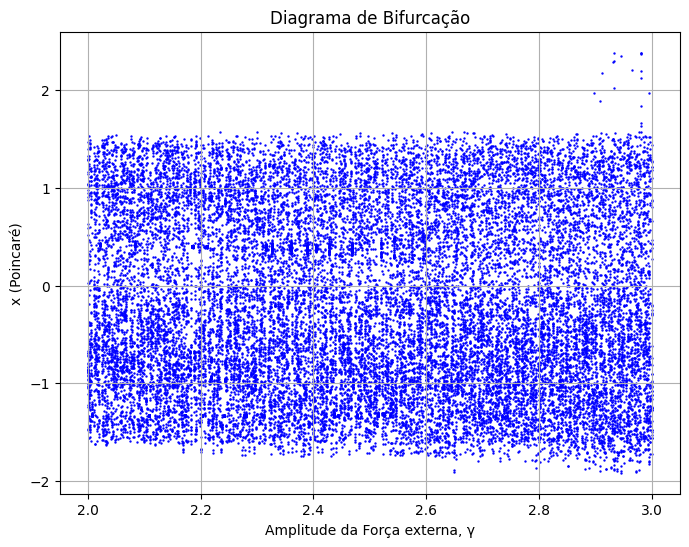

In [11]:
#eduardo Moura Ventorim
#aplicar diagrama de bifurcacao
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

M= 10.0
m= 0.2
l= 0.5
g= 9.81
k= -10.0
k2= 10.0
c_X= 0.05
c_th1= 0.01
c_th2= 0.01
w = 1.3 # frequencia da forca ext(rad/s)


t_total = 500 # tempo total de simulação
dt = 0.001
t_eval = np.arange(0, t_total, dt)
t_transient = 200 # Tempo de transiente a descartar
T_period = 2 * np.pi / w # Período da forçante
#  Definir os valores de amplitude da forca para varredura (ex.: de 0.3 a 0.7, com 200 pontos)
Amp_values = np.linspace(2, 3, 500)
#  Listas para armazenar os pontos do diagrama de bifurcação
x_bif = [] #
amp_bif = [] #
Z0 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1] #Laço para cada valor de gamma

for ampp in Amp_values:
  print("Simulando amplitude =", ampp)
  # --- D. Loop de Simulação Iterativa ---
  sol2 = solve_ivp(lambda t,y: odefunc(t, y,M, m, l, g, k, k2, c_X, c_th1, c_th2, ampp, w), [0, t_total], Z0, method='LSODA', rtol=1e-3, atol=1e-3)
  t_val = sol2.t
  x_val = sol2.y[0]
  n_trans = int(t_transient / T_period)
  n_samples = 50

  t_poincare = T_period * np.arange(
    n_trans,
    n_trans + n_samples
    )
  interp_x = interp1d(sol2.t, sol2.y[0], kind='cubic')

  x_pc = interp_x(t_poincare)
  for val in x_pc:
    amp_bif.append(ampp)
    x_bif.append(val)
# Plot do diagrama de bifurcação
plt.figure(figsize=(8,6))
plt.scatter(amp_bif, x_bif, s=0.5, color='blue')
plt.xlabel('Amplitude da Força externa, γ')
plt.ylabel('x (Poincaré)')
plt.title('Diagrama de Bifurcação')
plt.grid(True)
plt.show()

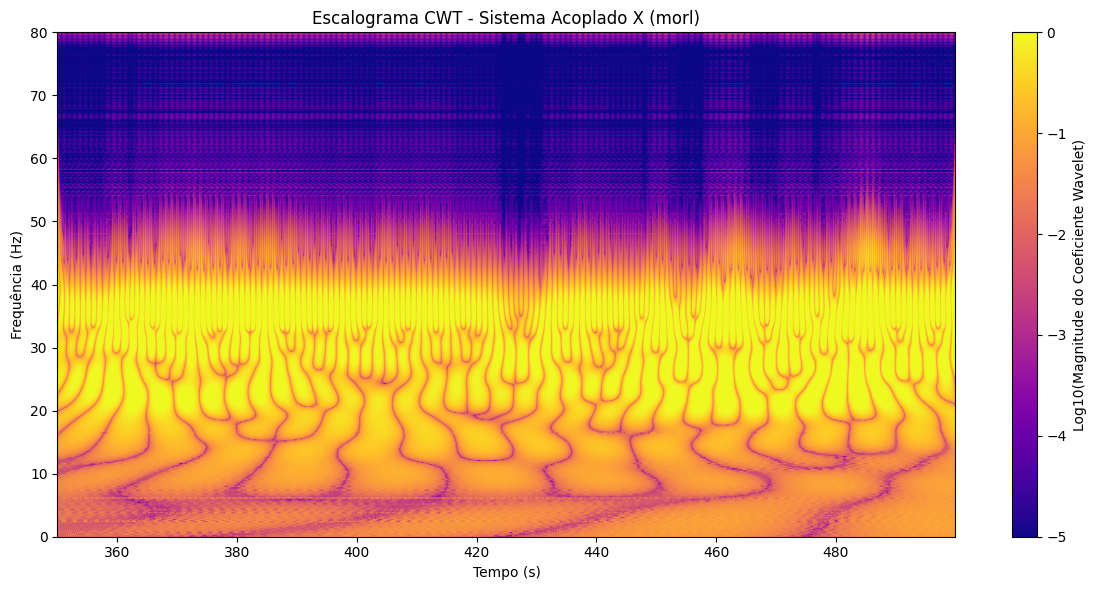

In [12]:
#wis
#wavelet nova
import sympy as sp
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pywt

# I. FUNÇÃO DE PLOTAGEM WAVELET
def plot_cwt_analysis(signal, time, title, wavelet_name='morl', scales=None, fmax=80.0,
                      v_min_log=-5.0, v_max_log=0.0):
    """
    Plota escalograma CWT com:
    - eixo Y crescendo de 0 até fmax (Hz),
    - seleção correta das frequências <= fmax,
    - ordenação ascendente das frequências antes de plotar,
    - colormap 'plasma'.
    """
    dt = time[1] - time[0]

    # escalas logarítmicas por padrão
    if scales is None:
        scales = np.power(2, np.linspace(np.log2(1), np.log2(8192), 512))

    coef, _ = pywt.cwt(signal, scales, wavelet_name)
    frequencies = pywt.scale2frequency(wavelet_name, scales) / dt  # array de mesmas dimensões que scales

    # Seleciona apenas frequências positivas <= fmax (visualização)
    mask = (frequencies > 0) & (frequencies <= fmax)
    if not np.any(mask):
        # se não houver nenhuma frequência dentro da banda, escolhe a mais próxima
        idx = np.argmin(np.abs(frequencies - fmax))
        mask = np.zeros_like(frequencies, dtype=bool)
        mask[idx] = True

    freqs_sel = frequencies[mask]
    coef_sel = coef[mask, :]

    # Garantir que as frequências estejam em ordem crescente (necessário para extent correto)
    sort_idx = np.argsort(freqs_sel)
    freqs_sel = freqs_sel[sort_idx]
    coef_sel = coef_sel[sort_idx, :]

    # Converter magnitude para log10 para visualização (evita saturação)
    log_coef = np.log10(np.abs(coef_sel) + 1e-12)

    # Plot (Y crescente: min -> max)
    fig, ax = plt.subplots(figsize=(12, 6))
    extent = [time.min(), time.max(), freqs_sel.min(), freqs_sel.max()]  # ymin < ymax

    im = ax.imshow(log_coef,
                   extent=extent,
                   aspect='auto',
                   cmap='plasma',
                   vmin=v_min_log,
                   vmax=v_max_log,
                   origin='lower')  # origin='lower' mantém Y crescente

    ax.set_title(f'Escalograma CWT - {title} ({wavelet_name})')
    ax.set_xlabel('Tempo (s)')
    ax.set_ylabel('Frequência (Hz)')
    ax.set_ylim(0.0, fmax)  # garante 0..fmax no eixo Y

    plt.colorbar(im, ax=ax, label='Log10(Magnitude do Coeficiente Wavelet)')
    plt.tight_layout()
    plt.show()
#desempacota resultados
X_b, th1_b, th2_b, pX_b, pth1_b, pth2_b = sol.y
# Combinação linear
signal_total = th2t
plot_cwt_analysis(signal_total,ttr, 'Sistema Acoplado X',
                  wavelet_name='morl', fmax=80.0, v_min_log=-5.0, v_max_log=0.0)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- A. Definir Parâmetros ---
M= 1.0      # kg (massa do carrinho)
m= 0.3      # kg (massa do pêndulo)
l= 0.5      # m (comprimento do pêndulo)
g= 9.81     # m/s^2
k= 20.0    # Mola linear (poço normal)
k2= -50.0    # Mola não-linear (poço duplo)
c_X= 0.1   # Amortecimento no carrinho
c_th1= 0.05 # Amortecimento no pêndulo 1
c_th2= 0.05 # Amortecimento no pêndulo 2
A= 20.0   # amplitude da força externa (rad/s)

t_total = 50        # Tempo total de simulação
dt = 0.01
t_eval = np.arange(0, t_total, dt)
t_transient = 20    # Tempo de transiente a descartar
T_period = 2 * np.pi / w  # Período da forçante

# Definir os valores de amplitude da forca para varredura (ex.: de 0.3 a 0.7, com 200 pontos)
Amp_values = np.linspace(4, 8, 50)

# Listas para armazenar os pontos do diagrama de bifurcação
x_bif = []      # Valores de x (na seção de Poincaré)
amp_bif = []  # Valores de amp correspondentes

# Condição inicial fixa para cada simulação
Z0 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
t_start = 0.0
t_end = 50.0
# Laço para cada valor de gamma
for ampp in Amp_values:
  print("Simulando amplitude =", ampp)
  # --- D. Loop de Simulação Iterativa  ---
  sol2 = solve_ivp(lambda t,y:
    odefunc(t, y,M, m, l, g, k, k2, c_X, c_th1, c_th2, A, ampp),
    [t_start, t_end],
    Z0,
    method='RK45',
    rtol=1e-4,
    atol=1e-6)

  t_val = sol2.t
  x_val = sol2.y[0]
  ind = np.where (t_val >= t_transient)[0]
  t_val_post = t_val[ind]
  x_val_post = x_val[ind]





In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import time
import matplotlib.pyplot as plt

# ==============================================================================
# --- CÉLULA 2: DEFINIÇÃO DAS FUNÇÕES DE SIMULAÇÃO ---
# ==============================================================================
# (Esta célula USA o 'dZ_dt_num' que você criou na célula anterior)

# --- A. Definir a 'odefunc' SIMPLES ---
def odefunc(t, Z, M_val, m_val, l_val, g_val, k_val, k2_val, c_X_val, c_th1_val, c_th2_val, F0_val, w_val):
    # Assumindo que 'dZ_dt_num' já existe
    return dZ_dt_num(t, *Z, M_val, m_val, l_val, g_val, k_val, k2_val, c_X_val, c_th1_val, c_th2_val, F0_val, w_val)
print("Função 'odefunc' (simples) definida.")

# --- B. Definir os Eventos (Paredes Duras - Do seu código) ---
def theta1_event_positive(t, Z, *args):
    return Z[1] - (np.pi/2)
theta1_event_positive.terminal = True
theta1_event_positive.direction = 1

def theta1_event_negative(t, Z, *args):
    return Z[1] + (np.pi/2)
theta1_event_negative.terminal = True
theta1_event_negative.direction = -1
print("Funções de Evento (Paredes Duras) definidas.")

# --- C. Definir a Função "Mestra" (Baseada no seu loop 'while') ---
def run_simulation_with_events(Z0_input, param_tuple_input, t_end=100.0, t_transient=80.0):
    t_start = 0.0
    Z_current = np.array(Z0_input)
    all_t_relevant = []
    all_Z_relevant = []
    rtol, atol = 1e-7, 1e-9

    while t_start < t_end:
        sol_segment = solve_ivp(
            odefunc, [t_start, t_end], Z_current,
            method='RK45', args=param_tuple_input,
            events=[theta1_event_positive, theta1_event_negative],
            rtol=rtol, atol=atol
        )

        t_segment, Z_segment = sol_segment.t, sol_segment.y
        mask = t_segment >= t_transient
        if np.any(mask):
            all_t_relevant.append(t_segment[mask])
            all_Z_relevant.append(Z_segment.T[mask, :])

        event_time, event_idx, Z_event_state = np.inf, -1, None
        if sol_segment.t_events[0].size > 0 and sol_segment.t_events[0][0] < event_time:
            event_time = sol_segment.t_events[0][0]
            Z_event_state = sol_segment.y_events[0][0]
            event_idx = 0
        if sol_segment.t_events[1].size > 0 and sol_segment.t_events[1][0] < event_time:
            event_time = sol_segment.t_events[1][0]
            Z_event_state = sol_segment.y_events[1][0]
            event_idx = 1

        if event_idx != -1:
            t_start = event_time
            Z_current = np.array(Z_event_state)
            Z_current[4] = -Z_current[4] # Inverte pth1
        else:
            t_start = t_end

    if not all_t_relevant: return -99.0
    try:
        sol_y_final = np.concatenate(all_Z_relevant, axis=0).T
        x_no_atrator = sol_y_final[0, :]
        if x_no_atrator.size == 0: return -98.0
        return np.max(np.abs(x_no_atrator))
    except Exception as e:
        return -97.0

print("Função 'run_simulation_with_events' (Mestra) definida.")

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time

# ==============================================================================
# --- 1. DEFINIÇÃO DA FUNÇÃO ODE (SEM PAREDES) ---
# ==============================================================================
# Redefinimos a odefunc para garantir que ela é a versão simples
def odefunc_simple(t, Z, M_val, m_val, l_val, g_val, k_val, k2_val, c_X_val, c_th1_val, c_th2_val, F0_val, w_val):
    # Chama diretamente a função do SymPy, sem verificar paredes
    return dZ_dt_num(t, *Z, M_val, m_val, l_val, g_val, k_val, k2_val, c_X_val, c_th1_val, c_th2_val, F0_val, w_val)

print("Função 'odefunc_simple' definida.")

# ==============================================================================
# --- 2. CONFIGURAÇÃO DO CÁLCULO ---
# ==============================================================================

# --- Resolução ---
# Sem as paredes, o código é rápido. Pode tentar 50 ou 100 direto.
res = 50

t_span = [0, 100]
t_transient = 80.0

# --- Grid (Slice Opção 3: th1 vs p_th1) ---
# Como não tem parede, podemos explorar um range maior de ângulos se quiser
th1_0_grid = np.linspace(-np.pi, np.pi, res) # De -180 a +180 graus
pth1_0_grid = np.linspace(-10.0, 10.0, res)

basins = np.zeros((res, res))

# Pontos de tempo para análise (apenas o final)
t_eval_atrator = np.linspace(t_transient, t_span[1], 100)

print(f"Grid {res}x{res} criado. Iniciando {res*res} simulações (Modo Rápido/Sem Paredes)...")
start_time = time.time()

# ==============================================================================
# --- 3. LOOP DE CÁLCULO ---
# ==============================================================================

for i, th1_0 in enumerate(th1_0_grid):
    for j, pth1_0 in enumerate(pth1_0_grid):

        # Condição Inicial 6D: [X, th1, th2, p_X, p_th1, p_th2]
        Z0 = [0.0, th1_0, 0.0, 0.0, pth1_0, 0.0]

        try:
            # Chamada SIMPLES ao solve_ivp (do início ao fim de uma vez)
            sol = solve_ivp(
                odefunc_simple,
                t_span,
                Z0,
                args=param_tuple,
                method='RK45',
                t_eval=t_eval_atrator # Pega apenas os pontos finais
            )

            if sol.success:
                # Métrica: Amplitude Máxima de X no estado estacionário
                x_no_atrator = sol.y[0, :]
                amplitude_max_X = np.max(np.abs(x_no_atrator))

                # --- SUA LÓGICA DE CLASSIFICAÇÃO ---
                # (Lembre-se de ajustar este valor '4.0' baseando-se no seu Teste Rápido!)
                if amplitude_max_X < 4.0:
                    basins[i, j] = 0  # Atrator Pequeno
                else:
                    basins[i, j] = 1  # Atrator Grande
                # -----------------------------------
            else:
                basins[i, j] = -99 # Falha numérica

        except Exception as e:
            basins[i, j] = -98 # Erro de execução

    # Barra de progresso simples
    if (i+1) % max(1, res // 10) == 0:
        print(f"Progresso: {((i+1)/res)*100:.0f}% completo")

end_time = time.time()
print(f"Cálculo finalizado em {end_time - start_time:.2f} segundos.")

# ==============================================================================
# --- 4. PLOTAGEM ---
# ==============================================================================

print("Plotando...")
plt.figure(figsize=(10, 8))
plt.imshow(
    basins.T,
    extent=[th1_0_grid.min(), th1_0_grid.max(), pth1_0_grid.min(), pth1_0_grid.max()],
    origin='lower',
    aspect='auto',
    cmap='coolwarm' # Azul para 0, Vermelho para 1
)
plt.colorbar(label='ID do Atrator (0 ou 1)')
plt.xlabel('Ângulo Inicial th1(0) (rad)')
plt.ylabel('Momento Inicial p_th1(0)')
plt.title(f'Bacia de Atração (Sem Paredes) @ res={res}x{res}')
plt.grid(False)
plt.show()